# **Práctica 1: Transferencia de aprendizaje y fine tuning**

## Modelo Preentrenado
Un modelo preentrenado es una red guardada que se entrenó previamente en un gran conjunto de datos, generalmente en una tarea de clasificación de imágenes a gran escala. Puede usar el modelo preentrenado tal como está o usar transferencia de aprendizaje para personalizar este modelo para una tarea determinada.



## Transferencia de aprendizaje
La intuición detrás del aprendizaje de transferencia para la clasificación de imágenes es que si un modelo se entrena en un conjunto de datos lo suficientemente grande y general, este modelo servirá efectivamente como un modelo genérico del mundo visual. A continuación, puede aprovechar estos mapas de características aprendidos sin tener que empezar de cero entrenando un modelo grande en un conjunto de datos grande.

Existen dos formas de personalizar un modelo previamente entrenado:

1. **Extracción de características:** use las representaciones aprendidas por una red anterior para extraer características significativas de nuevas muestras. Simplemente agregue un nuevo clasificador, que se entrenará desde cero, encima del modelo previamente entrenado para que pueda reutilizar los mapas de características aprendidos previamente para el conjunto de datos.

 No necesita (re)entrenar todo el modelo. La red convolucional base ya contiene características que son genéricamente útiles para clasificar imágenes. Sin embargo, la parte de clasificación final del modelo preentrenado es específica de la tarea de clasificación original y, posteriormente, específica del conjunto de clases en las que se entrenó el modelo.


2. **Fine tuning:** descongele algunas de las capas superiores de una base de modelo congelada y entrene conjuntamente las capas clasificadoras recién agregadas y las últimas capas del modelo base. Esto nos permite "afinar" las representaciones de características de orden superior en el modelo base para que sean más relevantes para la tarea específica.

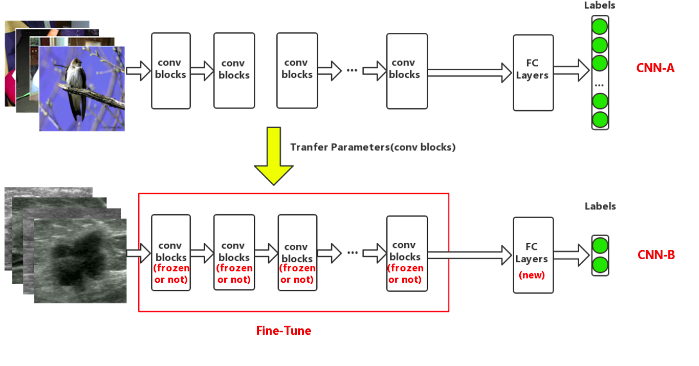


## Importamos las librerias de python a utilizar

In [1]:
import matplotlib.pyplot as plt # Visualización y gráficas
import numpy as np # Arrays y operaciones matriciales
import tensorflow as tf # Deep Learning

import os # operaciones de terminal

## Preprocesamiento de los datos

### Descargamos los datos
En este tutorial, utilizará un conjunto de datos que contiene varios miles de imágenes de gatos y perros. Descargue y extraiga un archivo zip que contenga las imágenes, luego cree un `tf.data.Dataset` para entrenamiento y validación usando la utilidad `tf.keras.utils.image_dataset_from_directory` . Puede obtener más información sobre cómo cargar imágenes en este [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 2s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Mostramos las primeras nueve imágenes y etiquetas del conjunto de entrenamiento:

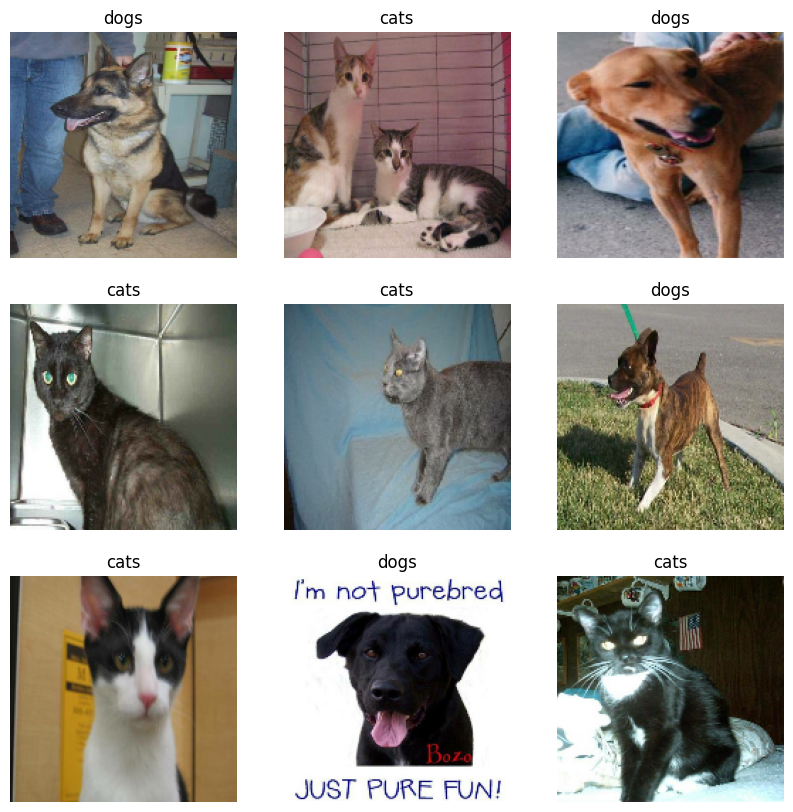

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como el conjunto de datos original no contiene un conjunto de prueba, creará uno. Para hacerlo, determine cuántos lotes de datos están disponibles en el conjunto de validación mediante `tf.data.experimental.cardinality` y luego mueva el 20 % de ellos a un conjunto de prueba.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Usar aumento de datos
Cuando no tiene un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras mediante la aplicación de transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como la rotación y el volteo horizontal. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento y reduce el [sobreajuste](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Puede obtener más información sobre el aumento de datos en este [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

**Nota**: estas capas solo están activas durante el entrenamiento, cuando llamas a `Model.fit` . Están inactivos cuando el modelo se usa en modo de inferencia en `Model.evaluate` o `Model.predict`.

Apliquemos repetidamente estas capas a la misma imagen y veamos el resultado.

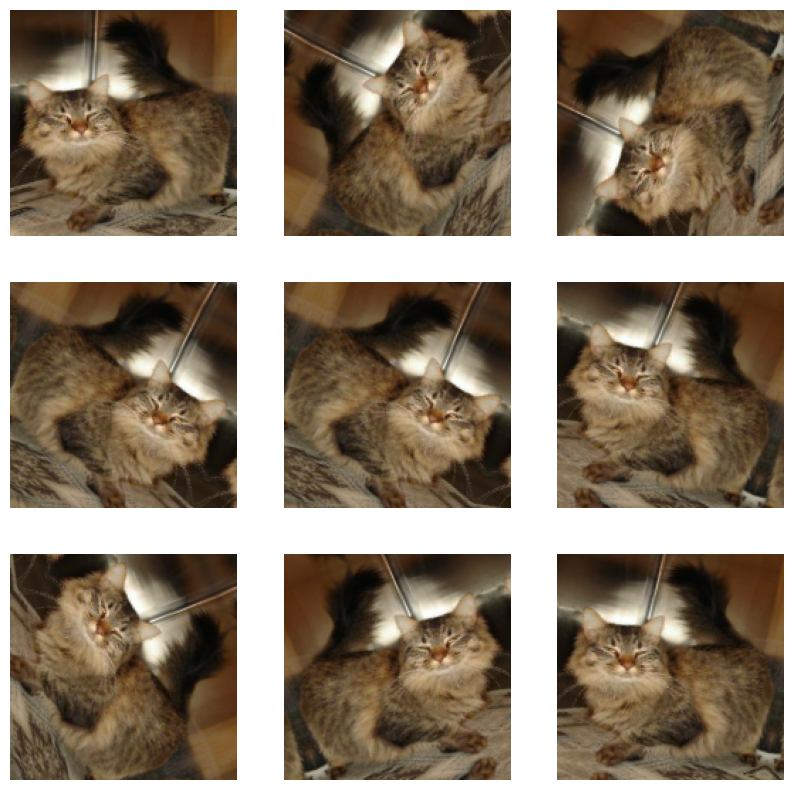

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Cambiar la escala de los valores de píxeles
En un momento, descargará `tf.keras.applications.MobileNetV2` para usarlo como su modelo base. Este modelo espera valores de píxel en `[-1, 1]` , pero en este punto, los valores de píxel en sus imágenes están en `[0, 255]` . Para volver a escalarlos, utilice el método de preprocesamiento incluido con el modelo.

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## ImageNET
ImageNet es una base de datos de imágenes anotadas creada por la investigadora Fei-Fei Li con las universidades de Stanford y Princeton como un recurso para la investigación en visión artificial. Cuenta con más de 14 millones de imágenes etiquetadas en más de 1000 clases. Su corpus de palabras proviene de WordNet, una base de datos del léxico del inglés organizada jerárquicamente en función del significado de las palabras.

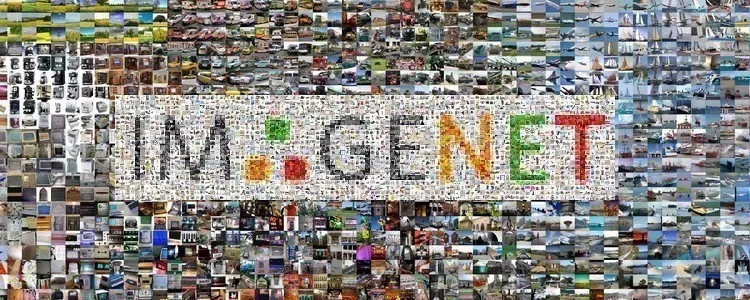

## Cree el modelo base a partir de las convnets preentrenadas
Creamos el modelo base a partir del modelo **MobileNet V2** desarrollado en Google. Esto se entrena previamente en el conjunto de datos de ImageNet, un gran conjunto de datos que consta de 1,4 millones de imágenes y 1000 clases. ImageNet es un conjunto de datos de entrenamiento de investigación con una amplia variedad de categorías como `jackfruit` y `syringe` . Esta base de conocimientos nos ayudará a clasificar perros y gatos a partir de nuestro conjunto de datos específico.

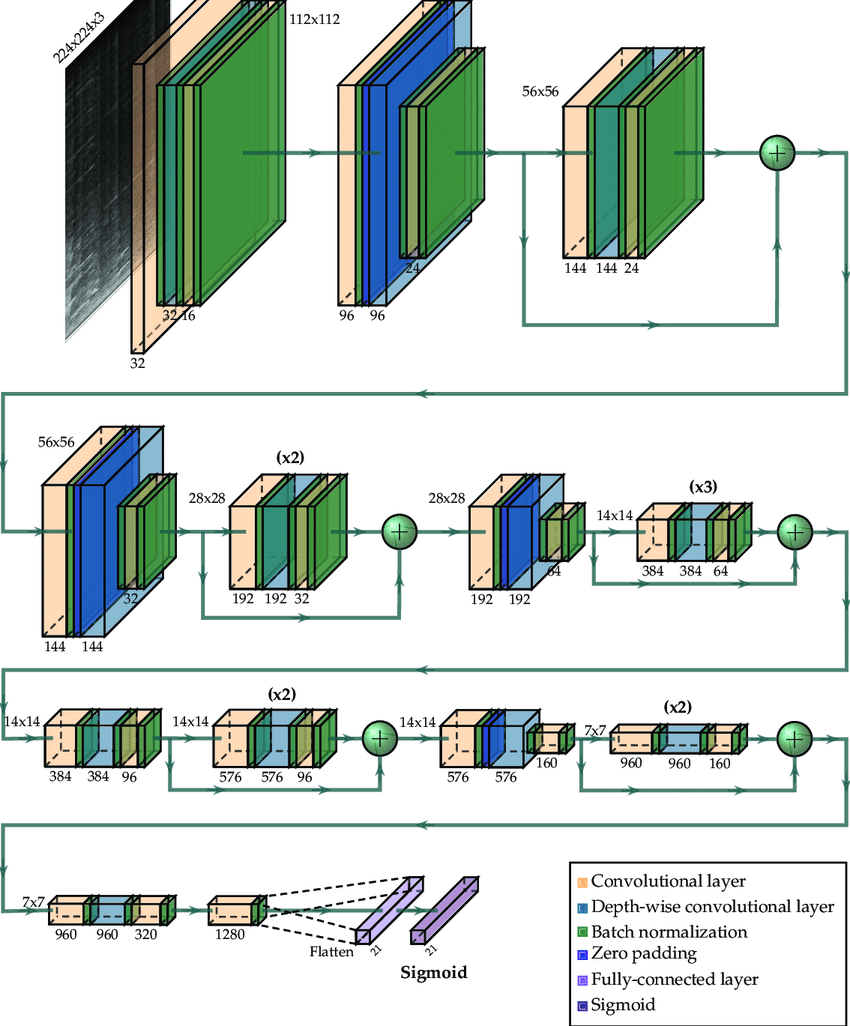

Primero, debe elegir qué capa de MobileNet V2 utilizará para la extracción de características. La última capa de clasificación (en "arriba", ya que la mayoría de los diagramas de modelos de aprendizaje automático van de abajo hacia arriba) no es muy útil. En su lugar, seguirá la práctica común de depender de la última capa antes de la operación de aplanado. Esta capa se denomina "capa de cuello de botella". Las características de la capa de cuello de botella conservan más generalidad en comparación con la capa final/superior.

Primero, cree una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar el argumento **include_top=False** , carga una red que no incluye las capas de clasificación en la parte superior, lo que es ideal para la extracción de características.


In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


Este extractor de características convierte cada imagen de `160x160x3` en un bloque de características de `5x5x1280` . Veamos qué le hace a un lote de imágenes de ejemplo:

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
En este paso, congelará la base convolucional creada en el paso anterior y la utilizará como extractor de características. Además, agrega un clasificador encima y entrena el clasificador de nivel superior.

### Congelar la base convolucional
Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Congelar (estableciendo layer.trainable = False) evita que los pesos en una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que establecer la bandera `trainable` de todo el modelo en False las congelará todas.

In [10]:
base_model.trainable = False

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

Imagen de ejemplo (no corresponde a la arquitectura):

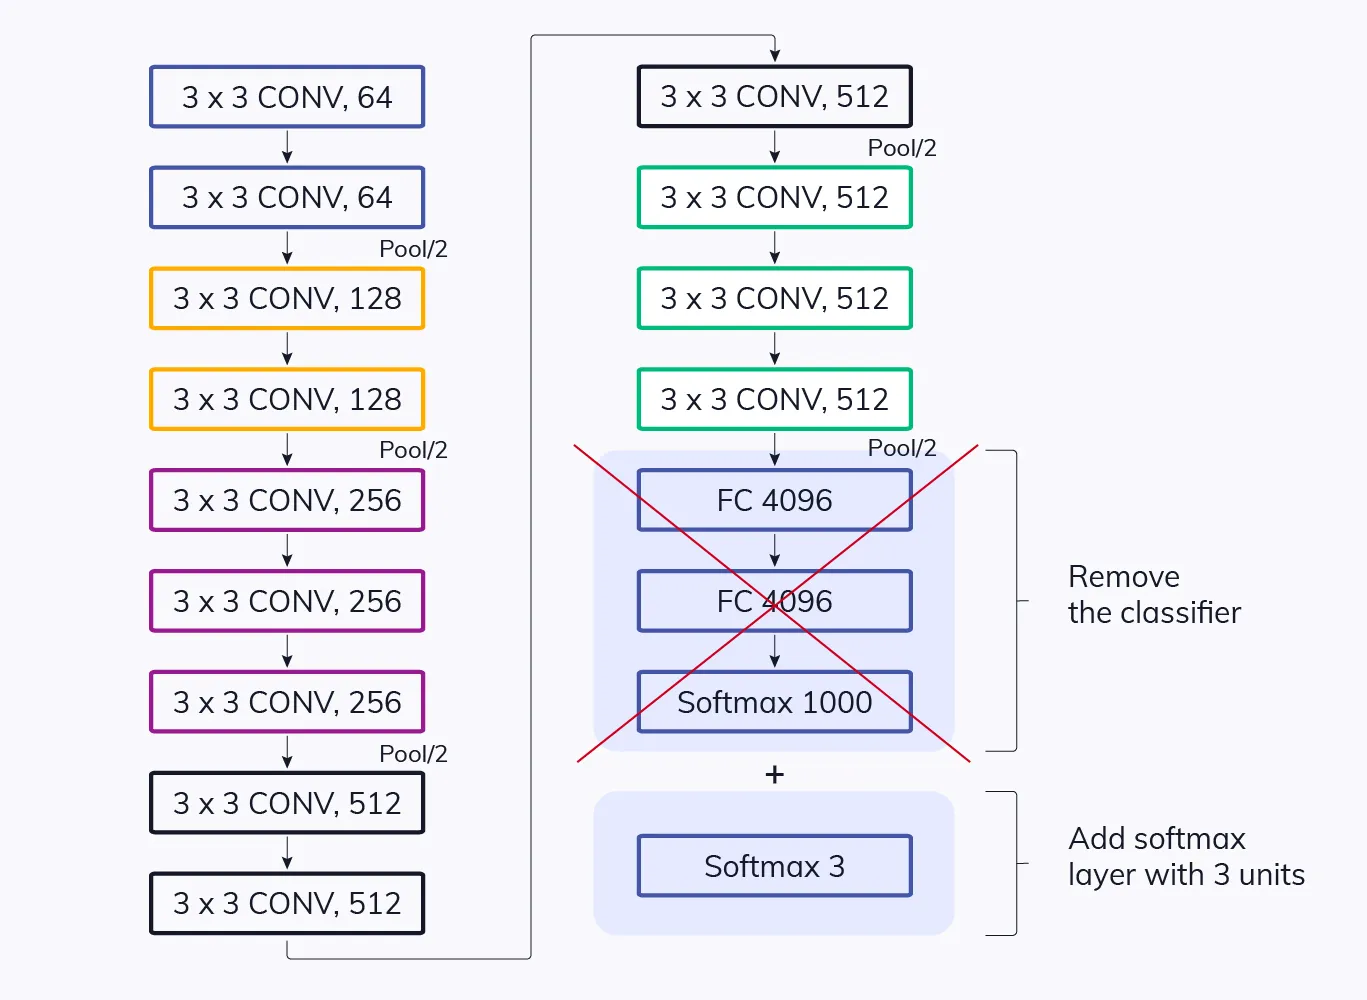

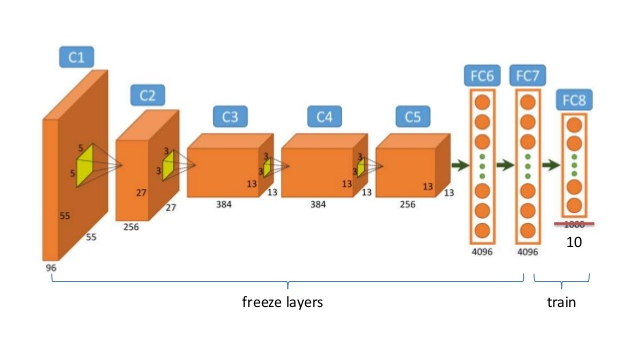

### Agregar un encabezado de clasificación


Para generar predicciones a partir del bloque de entidades, promedie las ubicaciones espaciales de `5x5` utilizando una capa `tf.keras.layers.GlobalAveragePooling2D` para convertir las entidades en un único vector de 1280 elementos por imagen.

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique una capa `tf.keras.layers.Dense` para convertir estas características en una sola predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un `logit` o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [13]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Cree un modelo encadenando las capas de aumento de datos, reescalado, `base_model` y extractor de características mediante la [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

### Compilar el modelo

Compile el modelo antes de entrenarlo. Dado que hay dos clases, use la pérdida `tf.keras.losses.BinaryCrossentropy` con from_logits=True ya que el modelo proporciona una salida lineal.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Entrenamos el modelo

Después de entrenar durante 10 épocas, debería ver una precisión de ~97 % en el conjunto de validación.


In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


26/26 [==============================] - 5s 51ms/step - loss: 0.8589 - accuracy: 0.4282


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.86
initial accuracy: 0.43


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 65ms/step - loss: 0.7634 - accuracy: 0.5530 - val_loss: 0.5824 - val_accuracy: 0.7265
Epoch 2/10
63/63 [==============================] - 4s 53ms/step - loss: 0.5490 - accuracy: 0.7245 - val_loss: 0.4150 - val_accuracy: 0.8601
Epoch 3/10
63/63 [==============================] - 5s 72ms/step - loss: 0.4442 - accuracy: 0.8085 - val_loss: 0.3181 - val_accuracy: 0.9158
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3632 - accuracy: 0.8535 - val_loss: 0.2543 - val_accuracy: 0.9356
Epoch 5/10
63/63 [==============================] - 4s 52ms/step - loss: 0.3151 - accuracy: 0.8785 - val_loss: 0.2143 - val_accuracy: 0.9505
Epoch 6/10
63/63 [==============================] - 5s 72ms/step - loss: 0.2907 - accuracy: 0.8840 - val_loss: 0.1852 - val_accuracy: 0.9653
Epoch 7/10
63/63 [==============================] - 3s 52ms/step - loss: 0.2667 - accuracy: 0.8975 - val_loss: 0.1638 - val_accuracy: 0.9678
Epoch 8/10
6

### Curvas de aprendizaje

Echemos un vistazo a las curvas de aprendizaje de la precisión/pérdida de capacitación y validación cuando se usa el modelo base de MobileNetV2 como un extractor de características fijas.

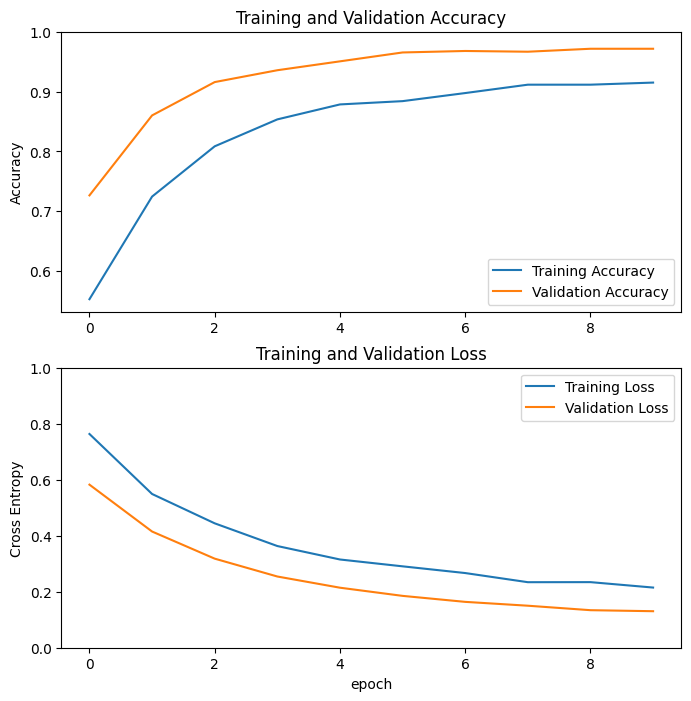

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
En el experimento de extracción de características, solo estaba entrenando algunas capas sobre un modelo base de MobileNetV2. Los pesos de la red preentrenada **no** se actualizaron durante el entrenamiento.



Una forma de aumentar aún más el rendimiento es entrenar (o "afinar") los pesos de las capas superiores del modelo preentrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar los pesos de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

Nota: Esto solo debe intentarse después de haber entrenado el clasificador de nivel superior con el modelo preentrenado establecido en no entrenable. Si agrega un clasificador inicializado aleatoriamente encima de un modelo previamente entrenado e intenta entrenar todas las capas juntas, la magnitud de las actualizaciones de gradiente será demasiado grande (debido a los pesos aleatorios del clasificador) y su modelo previamente entrenado olvidar lo que ha aprendido.

Además, debe intentar ajustar una pequeña cantidad de capas superiores en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que avanza, las funciones son cada vez más específicas para el conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para que funcionen con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

### Descongele las capas superiores del modelo.


Todo lo que necesita hacer es descongelar el `base_model` y configurar las capas inferiores para que no se puedan entrenar. Luego, debe volver a compilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento.

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


 Imagen de ejemplo (no corresponde a la arquitectura):

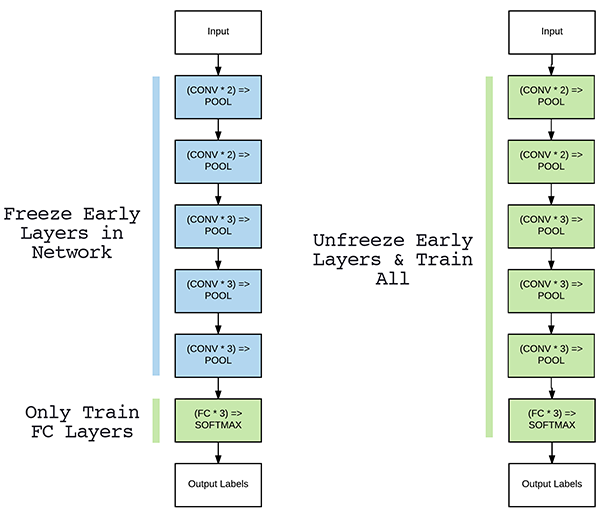

### Compilar el modelo

Como está entrenando un modelo mucho más grande y quiere readaptar los pesos previamente entrenados, es importante usar una tasa de aprendizaje más baja en esta etapa. De lo contrario, su modelo podría sobreajustarse muy rápidamente.

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [27]:
len(model.trainable_variables)

56

### Continuar entrenando al modelo

Si se entrenó antes para la convergencia, este paso mejorará su precisión en algunos puntos porcentuales.

In [28]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 [==============================] - 14s 94ms/step - loss: 0.1568 - accuracy: 0.9365 - val_loss: 0.0538 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1241 - accuracy: 0.9520 - val_loss: 0.0533 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 5s 82ms/step - loss: 0.0943 - accuracy: 0.9605 - val_loss: 0.0546 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0916 - accuracy: 0.9555 - val_loss: 0.0427 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 5s 75ms/step - loss: 0.0903 - accuracy: 0.9615 - val_loss: 0.0516 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0793 - accuracy: 0.9690 - val_loss: 0.0458 - val_accuracy: 0.9827
Epoch 17/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0754 - accuracy: 0.9720 - val_loss: 0.0348 - val_accuracy: 0.9889
Epoch

Después de un ajuste fino, el modelo alcanza casi el 98 % de precisión en el conjunto de validación.

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

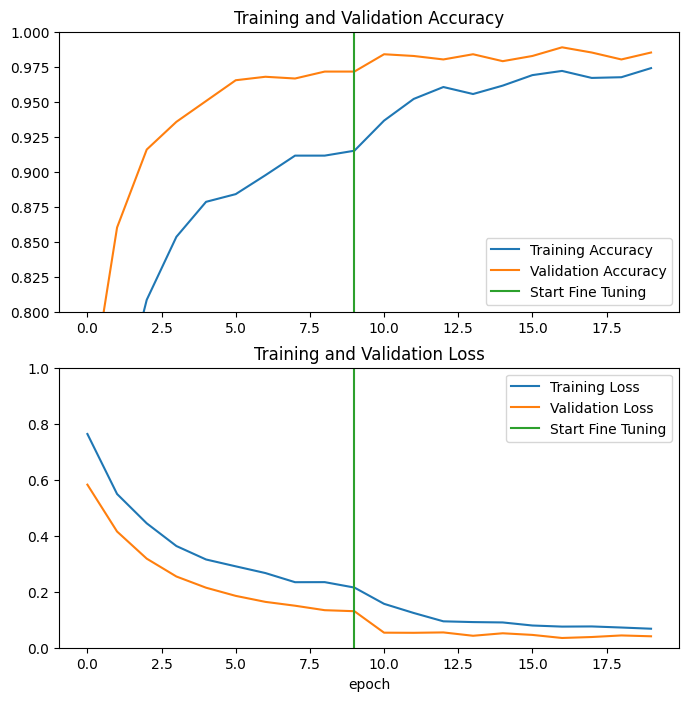

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluación y predicción

Finalmente, puede verificar el rendimiento del modelo en nuevos datos utilizando un conjunto de prueba.

In [31]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 36ms/step - loss: 0.0359 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Y ahora está todo listo para usar este modelo para predecir si su mascota es un gato o un perro.



Predictions:
 [1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0]
Labels:
 [1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0]


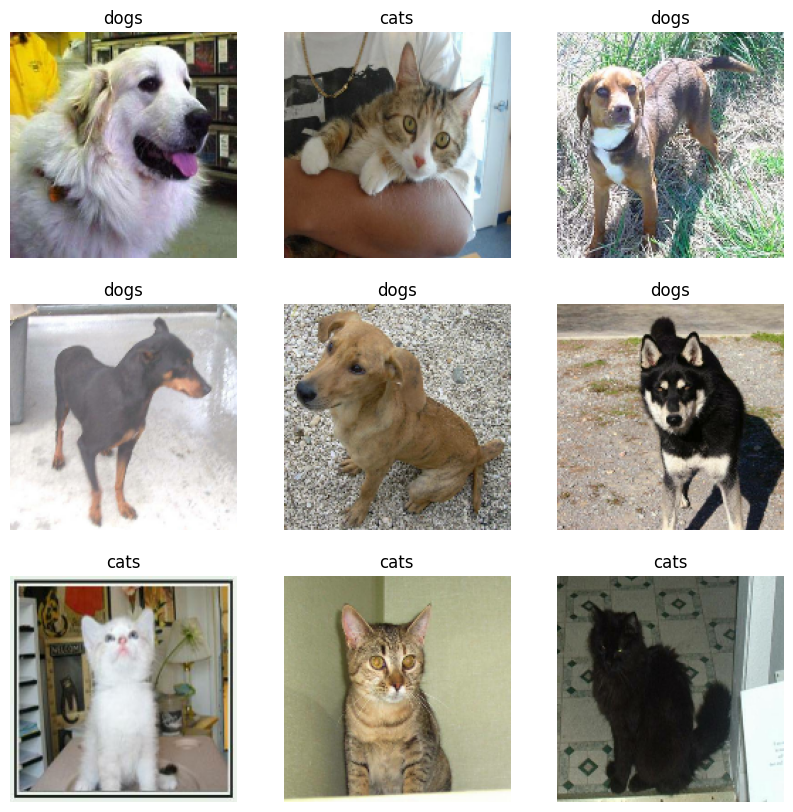

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

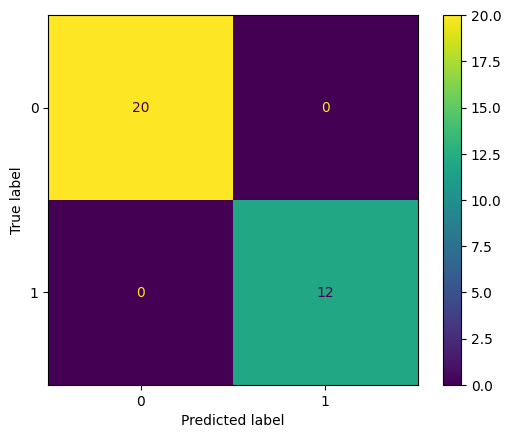

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(predictions, label_batch)

## Summary

* **Uso de un modelo previamente entrenado para la extracción de características:** cuando se trabaja con un conjunto de datos pequeño, es una práctica común aprovechar las características aprendidas por un modelo entrenado en un conjunto de datos más grande en el mismo dominio. Esto se hace instanciando el modelo previamente entrenado y agregando un clasificador completamente conectado en la parte superior. El modelo preentrenado se "congela" y solo los pesos del clasificador se actualizan durante el entrenamiento. En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y solo entrenó un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.

* **Ajuste fino de un modelo preentrenado:** para mejorar aún más el rendimiento, es posible que desee reutilizar las capas de nivel superior de los modelos preentrenados para el nuevo conjunto de datos a través del ajuste fino. En este caso, ajustó sus ponderaciones de modo que su modelo aprendiera características de alto nivel específicas del conjunto de datos. Esta técnica generalmente se recomienda cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo previamente entrenado.


Para obtener más información, visite [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


## Convertimos a TFLite
Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [34]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tf.lite
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [35]:
# Guardamos las etiquetas del clasificador
labels = '\n'.join(sorted(train_dataset.class_names))
print(labels)

with open('labels.txt', 'w') as f:
  f.write(labels)

cats
dogs


In [36]:
train_dataset.class_names

['cats', 'dogs']

Descargamos el modelo TFLite

In [37]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>